In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
from lib.DrugUtil import flatten, DrugUtil
import pickle

import plotly.express as px
from lib.FhirDataUtil import FhirDataUtil
from lib.CCSDataUtil import CCSDataUtil

def printmd(string):
    display(string)

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_colwidth', None)

_fhir_conditions_file = "input/fhir_20230423/fhir_conditions.csv"
_fhir_medications_file = "input/fhir_20230423/fhir_medications.csv"
_fhir_medications_ref_file = "input/fhir_20230423/fhir_medication_references2.csv"
_fhir_demographics_file = "input/fhir_20230423/fhir_demographics.csv"
_output_dir = 'output/'

_rxnorm_file = "input_static/RxTerms202203/RxTerms202203.txt"
_rxnorm_ingredients_file = "input_static/RxTerms202203/RxTermsIngredients202203.txt"
_rxclass_file = "input_static/_rxclass_2022-04-10.csv"

# Chart Review
_cr_file = 'input/chart_review/Chart_Review1.2b.xlsx'

_cache_dir = 'cache/'

In [3]:
fhirUtil = FhirDataUtil()
drugUtil = DrugUtil()

drugUtil.load(rxnorm_file=_rxnorm_file,
                        rxnorm_ingredients_file=_rxnorm_ingredients_file, 
                        rxclass_file=_rxclass_file)

fhirUtil.load_conditions(fhir_conditions_file=_fhir_conditions_file, remove_health_concerns=True)
fhirUtil.load_medications(medications_fhir_file=_fhir_medications_file, medications_ref_fhir_file=_fhir_medications_ref_file)
fhirUtil.load_demographics(fhir_demographics_file=_fhir_demographics_file)


Reading rxclass file...
Reading rxnorm file...
RAW FHIR conditions: 74880
FHIR conditions after pre-processing: 52030
----- Loading Medications ------
Raw FHIR records: 21695
After de-duplicated: 10395
Merge with reference counts:
left_only     6300
both          4019
right_only       0
Name: ref_merge, dtype: int64
Loaded FHIR medication records 55313  Includes multiple code mappings
Unique users with fhir medications:  1458
------  Done Loading Medications -----


In [28]:
fhir_meds = pd.read_csv(_fhir_medications_file)
fhir_meds_ref = pd.read_csv(_fhir_medications_ref_file)
print('RAW FHIR Medication References:', fhir_meds.shape[0])
fhir_meds['med_ref_id'] = fhir_meds['medication_reference'].str[11:]
fhir_meds = fhir_meds[fhir_meds['dose_text'] == 'ordered']
print(f'After de-duplicated: {fhir_meds.shape[0]}')
fhir_meds['authoredon_d'] = pd.to_datetime(fhir_meds['authoredon'])
fhir_meds = fhir_meds.merge(fhir_meds_ref[['id', 'coding_code']], left_on='med_ref_id', right_on='id', how="left", indicator='ref_merge')
print(fhir_meds['ref_merge'].value_counts())
fhir_meds[fhir_meds['ref_merge']=='left_only']['med_ref_id'].nunique()


RAW FHIR Medication References: 21695
After de-duplicated: 10395
both          48975
left_only      6338
right_only        0
Name: ref_merge, dtype: int64


6300

In [30]:
print('Unique Medications that are mapped with medicationReference:', 
      fhir_meds[fhir_meds['ref_merge']=='both']['med_ref_id'].nunique())

Unique Medications that are mapped with medicationReference: 4019


In [12]:
# RUN THIS CELL ONLY IF YOU WANT TO RE-MATCH INGREDIENTS (WILL TAKE A FEW HOURS TO MINUTES)

# replace coding_codes from fhir_meds_s that are nan (absent) with a drug_search coding code
# OUTPUT: fhir_meds_s with coding_code column filled from rx_norm

fhir_meds_s = fhirUtil.medications

fhir_meds_s = fhir_meds_s.merge(drugUtil.rxnormIngr, right_on='RXCUI', left_on='coding_code', how='left', indicator='ingr_merge')
fhir_meds_s = fhir_meds_s.rename(columns={'ING_RXCUI': 'fhir_ing_code', 'INGREDIENT': 'fhir_ing_name'})

fhir_meds_s['idx'] = range(0, len(fhir_meds_s))
nancodes = fhir_meds_s[fhir_meds_s['fhir_ing_code'].isnull()]
print('nancodes found', len(nancodes))
nancodes = drugUtil.add_ingredient_columns(nancodes, 'text')
fhir_meds_s = fhir_meds_s.merge(nancodes[['idx','ing_code', 'ing_name']], on='idx', how='left')
fhir_meds_s = fhir_meds_s.explode(['ing_code', 'ing_name'])
fhir_meds_s['fhir_ing_code'] = fhir_meds_s['fhir_ing_code'].fillna(fhir_meds_s['ing_code'])
fhir_meds_s['fhir_ing_name'] = fhir_meds_s['fhir_ing_name'].fillna(fhir_meds_s['ing_name'])
fhir_meds_s = fhir_meds_s.drop(['ing_name', 'ing_code'], axis=1)
fhir_meds_s.fhir_ing_code = fhir_meds_s.fhir_ing_code.astype('Int64')
# fhir_meds_s['fhir_ing_code'] = fhir_meds_s['fhir_ing_code'].astype('Int64')



nancodes found 46259
100 / 46259
200 / 46259
300 / 46259
400 / 46259
500 / 46259
600 / 46259
700 / 46259
800 / 46259
900 / 46259
1000 / 46259
1100 / 46259
1200 / 46259
1300 / 46259
1400 / 46259
1500 / 46259
1600 / 46259
1700 / 46259
1800 / 46259
1900 / 46259
2000 / 46259
2100 / 46259
2200 / 46259
2300 / 46259
2400 / 46259
2500 / 46259
2600 / 46259
2700 / 46259
2800 / 46259
2900 / 46259
3000 / 46259
3100 / 46259
3200 / 46259
3300 / 46259
3400 / 46259
3500 / 46259
3600 / 46259
3700 / 46259
3800 / 46259
3900 / 46259
4000 / 46259
4100 / 46259
4200 / 46259
4300 / 46259
4400 / 46259
4500 / 46259
4600 / 46259
4700 / 46259
4800 / 46259
4900 / 46259
5000 / 46259
5100 / 46259
5200 / 46259
5300 / 46259
5400 / 46259
5500 / 46259
5600 / 46259
5700 / 46259
5800 / 46259
5900 / 46259
6000 / 46259
6100 / 46259
6200 / 46259
6300 / 46259
6400 / 46259
6500 / 46259
6600 / 46259
6700 / 46259
6800 / 46259
6900 / 46259
7000 / 46259
7100 / 46259
7200 / 46259
7300 / 46259
7400 / 46259
7500 / 46259
7600 / 46259


/app/lib/DrugUtil.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.i_len = len(df)
/app/lib/DrugUtil.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.i_len = len(df)


In [9]:
# fhir_meds.to_csv(_cache_dir+'fhir_meds_mapped.csv')

In [32]:
fhir_meds = pd.read_csv(_cache_dir+'fhir_meds_mapped.csv')


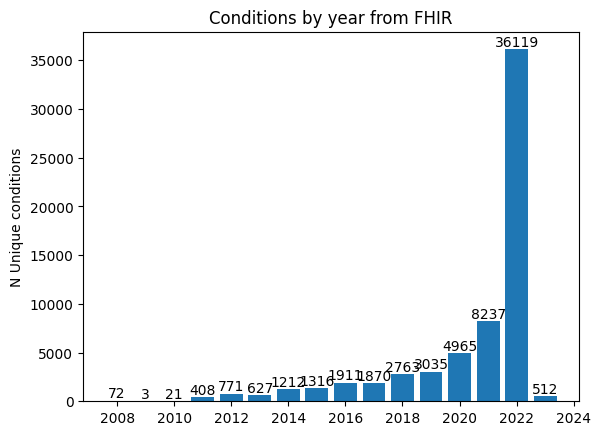

20389   2008-01-02 00:00:00+00:00
51221   2008-03-24 18:53:47+00:00
51220   2008-03-24 18:53:47+00:00
27492   2008-04-28 15:03:57+00:00
27490   2008-04-28 15:03:57+00:00
                   ...           
23234   2023-01-04 23:50:05+00:00
23228   2023-01-04 23:50:05+00:00
23227   2023-01-04 23:50:05+00:00
23230   2023-01-04 23:50:05+00:00
23233   2023-01-04 23:50:05+00:00
Name: authoredon_d, Length: 63842, dtype: datetime64[ns, UTC]

In [34]:
import matplotlib.pyplot as plt
fhir_meds['authoredon_d'] = pd.to_datetime(fhir_meds['authoredon'], errors="coerce", utc=True)
years = fhir_meds['authoredon_d'].dt.year.value_counts().reset_index(name="Medications")
bar = plt.bar(years['index'], years['Medications'])
plt.bar_label(bar)
plt.title('Conditions by year from FHIR')
plt.ylabel('N Unique conditions')
plt.show()
fhir_meds['authoredon_d'].dropna().sort_values()

In [25]:
fhir_meds['medication_id'].nunique()

10319

In [33]:
fhir_meds[~pd.isna(fhir_meds['fhir_ing_code'])]['medication_id'].nunique()


9798